In [1]:
# Licensed under a 3-clause BSD style license - see LICENSE.rst
"""Spectrum 1D ON/OFF Analysis"""

'Spectrum 1D ON/OFF Analysis'

# Spectrum 1D ON/OFF Analysis with 1LHAASO Catalog


This notebook demonstrates how to:
1. Import necessary libraries and modules.
2. Load and select a source from the 1LHAASO catalog.
3. Configure an `AnalysisSpectrumConfig` object.
4. Perform spectrum analysis using `AnalysisSpectrum`.
5. Save and inspect the results, including flux points and fit results.

---


In [2]:
# Standard library imports
import astropy.units as u

# Third-party imports from gammapy
from gammapy.catalog import SourceCatalog1LHAASO
from gammapy.data import Observation
from gammapy.datasets import Datasets
from gammapy.utils.scripts import make_path
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel, Models

# Third-party imports from regions
from regions import CircleSkyRegion

# feupy module imports
from feupy.utils.coordinates import convert_skycoord_to_dict
from feupy.analysis.config import CTAOAnalysisConfig
from feupy.analysis.core import CTAOAnalysis
from feupy.visualization.counts import show_hist_counts

In [3]:
from feupy.analysis.irfs import Irfs

In [5]:
len(Irfs.IRFS_OPTIONS)

162

### 1. Load and Select Source
In this section, we load the 1LHAASO catalog and select a specific source (1LHAASO J1219+2915) for analysis.

In [4]:
# Load the 1LHAASO catalog and select a source
catalog = SourceCatalog1LHAASO()
catalog.table

Source_Name,Model_a,RAJ2000,DECJ2000,pos_err,r39,r39_err,r39_ul,N0,N0_err,N0_ul,gamma,gamma_err,gamma_ul,E0,TS,TS100,Model_b,RAJ2000_b,DECJ2000_b,pos_err_b,r39_b,r39_err_b,r39_ul_b,N0_b,N0_err_b,N0_ul_b,gamma_b,gamma_err_b,gamma_ul_b,E0_b,TS_b,TS100_b,ASSO_Name,ASSO_Sep
,,deg,deg,deg,deg,deg,deg,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,,TeV,,,,deg,deg,deg,deg,deg,deg,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,,TeV,,,,deg
bytes20,bytes7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes16,float64
1LHAASO J0007+5659u,KM2A,1.86,57.0,0.12,--,--,0.18,3.3e-17,5e-18,--,3.1,0.2,--,50.0,86.5,43.6,WCDA,--,--,--,--,--,--,--,--,2.7000000000000002e-14,--,--,--,3.0,--,--,--,--
1LHAASO J0007+7303u,KM2A,1.91,73.07,0.07,0.17,0.03,--,3.41e-16,2.7e-17,--,3.4,0.12,--,50.0,361.0,171.6,WCDA,1.48,73.15,0.1,--,--,0.22,5.01e-13,1.1100000000000002e-13,--,2.74,0.11,--,3.0,141.6,--,CTA 1,0.12
1LHAASO J0056+6346u,KM2A,14.1,63.77,0.08,0.24,0.03,--,1.47e-16,1e-17,--,3.33,0.1,--,50.0,380.2,94.1,WCDA,13.78,63.96,0.15,0.33,0.07,--,1.45e-13,4.0999999999999996e-14,--,2.35,0.13,--,3.0,106.1,--,--,--
1LHAASO J0206+4302u,KM2A,31.7,43.05,0.13,--,--,0.27,2.4e-17,3e-18,--,2.62,0.16,--,50.0,96.0,82.8,WCDA,--,--,--,--,--,--,--,--,9e-15,--,--,--,3.0,--,--,--,--
1LHAASO J0212+4254u,KM2A,33.01,42.91,0.2,--,--,0.31,1.2e-17,3e-18,--,2.45,0.23,--,50.0,38.4,30.2,WCDA,--,--,--,--,--,--,--,--,7.000000000000001e-15,--,--,--,3.0,--,--,--,--
1LHAASO J0216+4237u,KM2A,34.1,42.63,0.1,--,--,0.13,1.8e-17,3e-18,--,2.58,0.17,--,50.0,102.0,65.6,WCDA,--,--,--,--,--,--,--,--,2.0000000000000003e-14,--,--,--,3.0,--,--,--,--
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1LHAASO J2200+5643u,KM2A,330.08,56.73,0.13,0.54,0.05,--,1.7e-16,1e-17,--,3.44,0.1,--,50.0,368.6,38.4,WCDA,330.38,56.73,0.2,0.43,0.07,--,3.8e-14,2.4e-14,--,1.77,0.28,--,3.0,75.7,--,--,--


In [8]:
source = catalog["1LHAASO J1219+2915"]

In [15]:
source = catalog[22]

In [12]:
source.row_index

22

In [14]:
catalog[22].name

'1LHAASO J1219+2915'

In [10]:
source.position

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (184.98, 29.25)>

In [11]:
source.name

'1LHAASO J1219+2915'

In [16]:
source.sky_model()

SkyModel(spatial_model=<gammapy.modeling.models.spatial.PointSpatialModel object at 0x7d947f9e4ca0>, spectral_model=<gammapy.modeling.models.spectral.PowerLawSpectralModel object at 0x7d947f9e4df0>)temporal_model=None)

In [17]:
source.spectral_model("KM2A")

In [18]:
source.spectral_model("WCDA")

### Annual Visibility

In [19]:
from feupy.analysis.irfs import calculate_annual_visibility_for_zenith_ranges

# Analysis Parameters
year=2025

# Define the target position
print(f"Annual Visibility Durations:{source.name}")
for observatory_name in ['cta_south', 'cta_north']:
    # Calculate annual visibility durations for each zenith range
    annual_visibility = calculate_annual_visibility_for_zenith_ranges(
        observatory_name=observatory_name, 
        source_position=source.position, 
        year=year
    )
    # Print results
    print(f"\n{observatory_name}:")
    for range_label, duration in annual_visibility.items():
        print(f'Zenith Angle {range_label}°: {duration:.2f} (hours)')

Annual Visibility Durations:1LHAASO J1219+2915

cta_south:
Zenith Angle 20°: 0.00 (hours)
Zenith Angle 40°: 0.00 (hours)
Zenith Angle 60°: 1135.50 (hours)

cta_north:
Zenith Angle 20°: 559.00 (hours)
Zenith Angle 40°: 568.00 (hours)
Zenith Angle 60°: 587.00 (hours)


### 2. Configure `CTAOAnalysis`
Here, we configure the `CTAOAnalysisConfig` object with observation, dataset, and analysis settings for the spectrum analysis.

In [20]:
# Create and configure CTAOAnalysisConfig
config = CTAOAnalysisConfig()


In [21]:
print(config)

CTAOAnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observation:
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        livetime: null
        offset: null
        position_angle: null
        required_irfs: [South, AverageAz, 20deg, 50h]
    datasets:
        type: 1d
        stack: true
        geom:
            wcs:
                skydir: {frame: null, lon: null, lat: null}
                binsize: 0.02 deg
                width: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 1.0 TeV, max: 10.0 TeV, nbins: 5}
                energy_true: {min: 0.5 TeV, max: 20.0 TeV, nbins: 16}
        map_selection: [counts, exposure, background, psf, edisp]
        background:
            method: null

In [22]:
from feupy.analysis.irfs import Irfs

In [24]:
len(Irfs.IRFS_OPTIONS)

162

In [25]:
# Define observation settings
position = source.position.icrs

config.observation.obs_cone = convert_skycoord_to_dict(position)
# Define o "ponto central" (descontando o offset) da observação no céu, convertido para dicionário (RA, Dec).

config.observation.offset = 0.5 * u.deg 
# Offset radial entre o centro da observação e o centro da região ON. Simula observações em “wobble mode”.

config.observation.position_angle = 0 * u.deg 
# Ângulo de rotação da câmera em torno do centro do campo de visão. Aqui está fixo em 0°.

config.observation.livetime = 50 * u.h 
# Tempo de exposição total (duração da observação simulada).

config.observation.required_irfs = ["South", "AverageAz", "40deg", "50h"]
# Define qual conjunto de IRFs será usada:

# South: observatório do hemisfério sul (CTAO-Sul)
# AverageAz: IRFs médios em azimute
# 40deg: zenital
# 50h: IRFs optimizadas para 50 horas de observação

# Configure dataset settings
config.datasets.map_selection = ["edisp", "background", "exposure"]
# Significado:
# Essa linha define quais componentes do instrumento devem ser usados na criação do dataset. 
# Cada item é uma "camada" que pode ser incluída no modelo da simulação ou análise.

#     "edisp" → Energy dispersion: aplica a matriz de dispersão de energia, que simula o desvio entre energia verdadeira e reconstruída.

#     "background" → adiciona o modelo de fundo (por exemplo, de ruído cósmico ou instrumental).

#     "exposure" → considera a exposição efetiva (produto da área efetiva e tempo de observação).

config.datasets.safe_mask.methods = ["bkg-peak"]
# Significado:
# Define o método usado para calcular a região segura de energia (safe_mask) no espectro.

#     "bkg-peak" significa que o Gammapy vai buscar o pico da contagem de fundo e considerar como confiável 
# somente a faixa de energia abaixo desse pico (onde o ruído não domina).
# Isso evita usar faixas de energia onde o modelo do fundo é muito incerto.

config.datasets.safe_mask.parameters = {"aeff_percent": 10}
# Significado:
# Esse parâmetro é complementar ao método de máscara segura e é usado, por exemplo, no método "aeff-default" ou "aeff-max" 
# (caso fosse escolhido). Ele define que a energia mínima confiável será aquela onde a área efetiva (effective area) 
# atinge 10% do valor máximo.
    
config.datasets.containment_correction = False
# Significado:
# Indica se o Gammapy deve aplicar uma correção de contenção angular para a região espectral.

#     True → corrige o fluxo para levar em conta que a PSF (função de espalhamento do ponto) pode jogar fótons fora da região analisada.

#     False → não aplica essa correção, assumindo que o modelo já considera a fração de fótons dentro da região.

# Recomendado deixar como False quando se usa espectros extraídos de regiões ON/OFF fixas e pequenas, como em CTA.

config.datasets.use_region_center = True
# Por padrão (True), o maker avalia os IRFs apenas no centro da região ON.
# Isto é válido apenas para fontes pontuais ou muito pequenas.
# Mas para fontes estendidas, isso ignoraria variações no IRF dentro da região.
# Com False, Gammapy faz o average dos IRFs por toda a região ON


config.datasets.on_region = convert_skycoord_to_dict(position)
config.datasets.on_region.radius = 0.5 * u.deg
# Define a região espectral ON: centro (posição da fonte) e raio (0.5°).

config.datasets.stack = False
# Indica que os datasets não serão empilhados. Útil para fazer análise por observação individual.

config.datasets.on_off.acceptance = 1
config.datasets.on_off.acceptance_off = 5
# Fatores de aceitação:

# ON = 1 → normalização da região ON

# OFF = 5 → a região OFF cobre 5× a área da ON (relacionado ao número de regiões OFF refletidas)


# Configure energy axes
config.datasets.geom.axes.energy.min = 30 * u.GeV
config.datasets.geom.axes.energy.max = 300 * u.TeV
config.datasets.geom.axes.energy.nbins = 12
# Define o range e número de bins da energia reconstruída, usada nos plots e ajuste.

config.datasets.geom.axes.energy_true.min = 3 * u.GeV
config.datasets.geom.axes.energy_true.max = 500 * u.TeV
config.datasets.geom.axes.energy_true.nbins = 15
# Faixa de energia usada internamente nas simulações (com dispersão de energia). Mais larga para capturar todos os eventos.


config.flux_points.energy.min = 30 * u.GeV
config.flux_points.energy.max = 300 * u.TeV
config.flux_points.energy.nbins = 12
config.flux_points.source = "source"
# Configura os pontos de fluxo (flux points) que podem ser calculados após o ajuste do espectro.
    
# Configure sensitivity settings
config.sensitivity.gamma_min = 5 # Número mínimo de fótons esperados (excesso) para considerar uma detecção.
config.sensitivity.n_sigma = 3 # Significância mínima (em sigma) para detecção.
config.sensitivity.bkg_syst_fraction = 0.10 # Erro sistemático do fundo (assumido como 10%) incluído no cálculo de sensibilidade.

config.statistics.n_obs = 1 # Número de observações

DATA_PATH = make_path(f'./data/')
DATA_PATH.mkdir(parents=True, exist_ok=True)

config.sensitivity.data_path = DATA_PATH
# Print configuration to verify
print(config)


CTAOAnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observation:
        obs_cone: {frame: icrs, lon: 184.97999684579457 deg, lat: 29.250002038380092 deg,
            radius: null}
        livetime: 50.0 h
        offset: 0.5 deg
        position_angle: 0.0 deg
        required_irfs: [South, AverageAz, 40deg, 50h]
    datasets:
        type: 1d
        stack: false
        geom:
            wcs:
                skydir: {frame: null, lon: null, lat: null}
                binsize: 0.02 deg
                width: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 30.0 GeV, max: 300.0 TeV, nbins: 12}
                energy_true: {min: 3.0 GeV, max: 500.0 TeV, nbins: 15}
        map_selection: [edisp, background, exposu

### 3. Running Spectrum Analysis
In this section, we create an instance of `CTAOAnalysis` and perform the spectrum analysis based on the configured settings. The process includes simulating observations, running fits, and extracting flux points.

In [26]:
# Create and run spectrum analysis
analysis = CTAOAnalysis(config)

INFO:feupy.analysis.config:Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


In [28]:
# Simulate observation and spectrum
analysis.simulate_observation()

INFO:feupy.analysis.core:Creating the pointing.
INFO:feupy.analysis.core:
 ON center:
<SkyCoord (ICRS): (ra, dec) in deg
    (184.97999685, 29.25000204)>
INFO:feupy.analysis.core:
 Obsevation offset:
0.5 deg
INFO:feupy.analysis.core:
Pointing position:
<SkyCoord (ICRS): (ra, dec) in deg
    (184.97999685, 29.75000204)>

/home/phoenix/miniconda3/envs/gammapy-1.3/lib/python3.9/site-packages/gammapy/data/pointing.py:157: GammapyDeprecationWarning: Passing mode is deprecated and the argument will be removed in Gammapy 1.3. pointing mode is deduced from whether fixed_icrs or fixed_altaz is given
  warnings.warn(
INFO:feupy.analysis.core:
Pointing:
FixedPointingInfo:

mode:        PointingMode.POINTING
coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (184.97999685, 29.75000204)>

INFO:feupy.analysis.core:
Setting observation parameters.
INFO:feupy.analysis.core:
irfs: CTAO South (40deg-50h)
INFO:feupy.analysis.core:
location: (1953830.40071076, -5461745.48215685, -2648150.15076259) m
INFO

In [30]:
source.spectral_model("WCDA").parameters.to_table()

type,name,value,unit,error,min,max,frozen,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
,index,2.6700e+00,,1.700e-01,nan,nan,False,,
,amplitude,3.4000e-14,TeV-1 s-1 cm-2,6.000e-15,nan,nan,False,,
,reference,3.0000e+00,TeV,0.000e+00,nan,nan,True,,


In [31]:
model_simu =  PowerLawSpectralModel(
    index=2.67,
    amplitude=3.4e-14 * u.Unit("cm-2 s-1 TeV-1"),
    reference=3* u.TeV,
)
model_source = SkyModel(spectral_model=model_simu, name="source")


In [32]:
analysis.get_spectrum_dataset(model_source)

INFO:feupy.analysis.core:Creating the background Maker.
INFO:feupy.analysis.core:Getting the observation.
INFO:feupy.analysis.core:
Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51546.08
	duration          : 180000.00 s
	pointing (icrs)   : 185.0 deg, 29.8 deg

	deadtime fraction : 0.0%


INFO:feupy.analysis.core:Getting the reference Dataset.
INFO:feupy.analysis.core:
reference: SpectrumDataset
---------------

  Name                            : 0 

  Total counts                    : 0 
  Total background counts         : 0.00
  Total excess counts             : 0.00

  Predicted counts                : 0.00
  Predicted background counts     : 0.00
  Predicted excess counts         : nan

  Exposure min                    : 0.00e+00 m2 s
  Exposure max                    : 0.00e+00 m2 s

  Number of total bins            : 12 
  Number of fit bins              : 0 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) 

In [33]:
print(analysis.spectrum_dataset)

SpectrumDataset
---------------

  Name                            : 0 

  Total counts                    : 18867 
  Total background counts         : 12041.10
  Total excess counts             : 6825.90

  Predicted counts                : 18863.97
  Predicted background counts     : 12041.10
  Predicted excess counts         : 6822.87

  Exposure min                    : 3.04e-10 m2 s
  Exposure max                    : 4.31e+11 m2 s

  Number of total bins            : 12 
  Number of fit bins              : 10 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -294128.90

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index                      

In [34]:
analysis.get_datasets()

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str5,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
obs-0,19108,7153.0,54.08297992294989,11955.0,13147.166666666668,13147.166666666668,nan,3.043444682015313e-10,431314192528.1135,180000.0,180000.0,0.10615555555555556,0.06641666666666667,0.039738888888888886,12,10,wstat,4500.382638087901,59775,10.0,50.0,0.2


In [35]:
print(analysis.datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : obs-0
  Instrument : CTA
  Models     : 




In [36]:
analysis.datasets.info_table()

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str5,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
obs-0,19108,7153.0,54.08297992294989,11955.0,13147.166666666668,13147.166666666668,nan,3.043444682015313e-10,431314192528.1135,180000.0,180000.0,0.10615555555555556,0.06641666666666667,0.039738888888888886,12,10,wstat,4500.382638087901,59775,10.0,50.0,0.2


In [37]:
analysis.set_models(Models(model_source))

INFO:feupy.analysis.core:Reading model.
INFO:feupy.analysis.core:Models

Component 0: SkyModel

  Name                      : source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.670   +/-    0.00             
    amplitude                     :   3.40e-14   +/- 0.0e+00 1 / (TeV s cm2)
    reference             (frozen):      3.000       TeV         




In [38]:
print(analysis.datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : obs-0
  Instrument : CTA
  Models     : ['source']




In [39]:
analysis.run_fit()

INFO:feupy.analysis.core:Fitting datasets.
INFO:feupy.analysis.core:OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 40
	total stat : 9.69

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [40]:
analysis.fit_result.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
,index,2.6701e+00,,1.636e-02,nan,nan,False,,
,amplitude,3.5647e-14,TeV-1 s-1 cm-2,1.453e-15,nan,nan,False,,
,reference,3.0000e+00,TeV,0.000e+00,nan,nan,True,,


In [41]:
analysis.get_flux_points()

INFO:feupy.analysis.core:Calculating flux points.
INFO:gammapy.estimators.points.core:Inferred format: gadf-sed
INFO:feupy.analysis.core:
      e_ref                 dnde          ...      sqrt_ts      
       GeV            1 / (TeV s cm2)     ...                   
------------------ ---------------------- ... ------------------
 44.03397802866209                    nan ...                nan
 94.86832980505132  3.704184007972238e-10 ... 31.320774674540374
204.38762071738844 4.4387309958282787e-11 ... 29.817018851328154
  440.339780286621  5.831324882332081e-12 ...  29.82328799072549
 948.6832980505134  8.356398920503322e-13 ... 31.786891109681353
2043.8762071738831 1.0026658478425472e-13 ... 21.339143567389513
 4403.397802866211 1.2544284983106486e-14 ... 12.950375850462937
 9486.832980505136 1.0416933562695182e-15 ...  7.077749036016513
20438.762071738816 2.1823113145550282e-16 ... 5.9862495163517115
 44033.97802866208  3.320448853048159e-17 ...   4.23291273147559
  94868.329805051

In [42]:
analysis.flux_points

In [43]:
# Run the sensitivity analysis
analysis.compute_sensitivity()

INFO:feupy.analysis.core:
Creating ON/OFF Dataset:
INFO:feupy.analysis.core:
ON/OFF Dataset:
SpectrumDatasetOnOff
--------------------

  Name                            : 7S86ULBn 

  Total counts                    : 19196 
  Total background counts         : 12012.60
  Total excess counts             : 7183.40

  Predicted counts                : 19171.02
  Predicted background counts     : 12015.67
  Predicted excess counts         : 7155.36

  Exposure min                    : 3.04e-10 m2 s
  Exposure max                    : 4.31e+11 m2 s

  Number of total bins            : 12 
  Number of fit bins              : 10 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 5.35

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatia

In [44]:
# Write the sensitivity table to a file (CSV in this case)
analysis.write_table_sensitivity()

INFO:feupy.analysis.core:Table (sens_CTAO-South_40deg_50h_livetime50.0h.fits) stored to data.


In [45]:
# Read the sensitivity table back if needed
sensitivity_table = analysis.read_table_sensitivity()

In [46]:
# Print the sensitivity table summary
print("\nSensitivity Table:")
print(sensitivity_table)


Sensitivity Table:
      e_ref              e_min        ...  criterion     on_radii 
       GeV                GeV         ...                  deg    
------------------ ------------------ ... ------------ -----------
 44.03397802866209 30.000000000000004 ...          bkg   6.598e-01
 94.86832980505132   64.6330407009565 ...          bkg   1.583e-01
204.38762071738844 139.24766500838334 ...          bkg   1.147e-01
  440.339780286621  300.0000000000002 ... significance   8.125e-02
 948.6832980505134  646.3304070095651 ... significance   6.475e-02
2043.8762071738831 1392.4766500838325 ... significance   5.125e-02
 4403.397802866211 3000.0000000000027 ... significance   4.175e-02
 9486.832980505136  6463.304070095652 ... significance   3.625e-02
20438.762071738816 13924.766500838328 ...        gamma   3.325e-02
 44033.97802866208 30000.000000000007 ...        gamma   2.875e-02
  94868.3298050513  64633.04070095648 ...        gamma   2.575e-02
 204387.6207173884  139247.6650083832 ... 

In [47]:
table_sens = analysis.table_sens

/home/phoenix/Coding/GitHub/feupy/feupy/visualization/sensitivity.py:193: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="lower left", scatterpoints=1, handlelength=3, fontsize=8)


<Axes: xlabel='Energy [$\\mathrm{GeV}$]', ylabel='Flux Sensitivity [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>

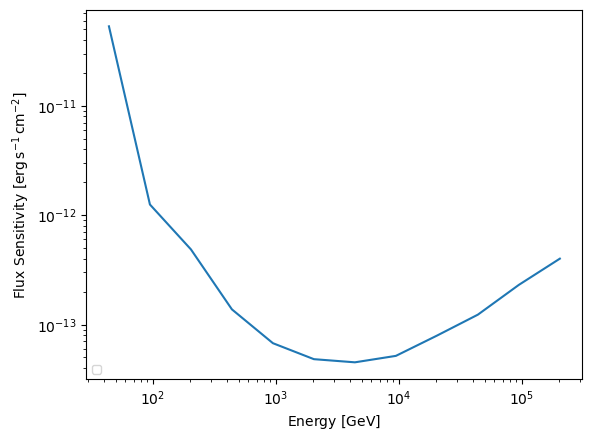

In [48]:
from feupy.visualization.sensitivity import plot_sensitivity_from_table

plot_sensitivity_from_table(table_sens)

In [49]:
table = analysis.datasets.info_table()
table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str5,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
obs-0,19108,7153.0,54.08297992294989,11955.0,19109.983683187875,11954.62684795683,7155.356835231039,3.043444682015313e-10,431314192528.1135,180000.0,180000.0,0.10615555555555556,0.06641666666666667,0.039738888888888886,12,10,wstat,9.694071968708512,59775,10.0,50.0,0.2


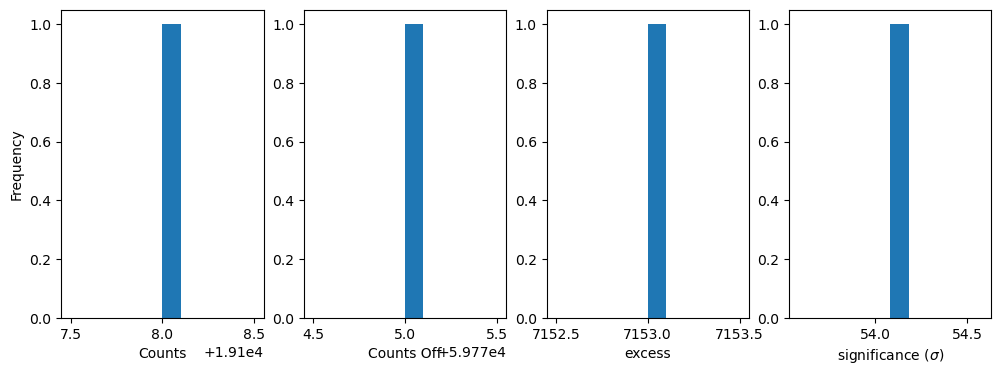

In [50]:
show_hist_counts(table)

In [51]:
analysis.flux_points.data.to_table()

INFO:gammapy.estimators.points.core:Inferred format: gadf-sed


e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,norm,norm_err,norm_errn,norm_errp,norm_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,stat_scan,is_ul,counts,success,norm_scan
GeV,GeV,GeV,1 / (TeV s cm2),GeV / (TeV s cm2),GeV2 / (TeV s cm2),,,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,float64[11],bool,float64[1],bool,float64[11]
44.03397802866209,30.000000000000004,64.6330407009565,2.8003430223994658e-09,1.0125824230288375e-07,4.2136434699739666e-06,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,0.0,nan .. nan,False,0.0,False,0.2 .. 4.999999999999999
94.86832980505132,64.6330407009565,139.24766500838334,3.6072580389302325e-10,2.8101512472481697e-08,2.5193611600134197e-06,1.026869707682667,0.03539994272730616,0.03531598244469473,0.035494142809573775,1.0981927501101663,980.9909262133297,31.320774674540374,11151.566630078036,3272.1055,1.9221333786845207e-05,980.9909454346634,616.7521965823835 .. 7995.692235821509,False,11152.0,True,0.2 .. 4.999999999999999
204.38762071738844,139.24766500838334,300.0000000000002,4.646684515198129e-11,7.798821955440502e-09,1.5063402254636843e-06,0.9552469037461685,0.03555554952267556,0.035430504612532,0.03568765136942297,1.026873748705482,889.0546131804585,29.817018851328154,5684.016813689863,2147.619,5.587935447692871e-08,889.0546132363379,530.8895738003193 .. 7081.746714182023,False,5684.0,True,0.2 .. 4.999999999999999
440.339780286621,300.0000000000002,646.3304070095651,5.985620310707061e-12,2.16435410557421e-09,9.006493038250571e-07,0.9742223160899504,0.04131107218861372,0.04097103056943679,0.04165194102554662,1.0582086719959325,889.4285065777513,29.82328799072549,1316.005245785861,883.20557,2.2293534129858017e-08,889.4285066000448,504.64391015988804 .. 3761.7147121957823,False,1316.0,True,0.2 .. 4.999999999999999
948.6832980505134,646.3304070095651,1392.4766500838325,7.710368626655371e-13,6.00658499588912e-10,5.385032908026255e-07,1.083787212405717,0.04992961049496215,0.04930982215159178,0.05055551086718583,1.186167018153605,1010.4064464187395,31.786891109681353,650.9961172385406,561.396,2.379420038778335e-08,1010.4064464425337,568.6992234706468 .. 2205.616611605643,False,651.0,True,0.2 .. 4.999999999999999
2043.8762071738831,1392.4766500838325,3000.0000000000027,9.93210081377325e-14,1.6669667509544822e-10,3.2197415017553226e-07,1.009520409269416,0.075931235827443,0.07421876768528692,0.07767785978215566,1.1684835016809931,455.3590481896613,21.339143567389513,204.9845195181718,191.58432,1.1843458196381107e-06,455.3590493740071,232.3589373771083 .. 879.0879615554727,False,205.0,True,0.2 .. 4.999999999999999
4403.397802866211,3000.0000000000027,6463.304070095652,1.2794022095639581e-14,4.6262196417590136e-11,1.925101576013436e-07,0.9804801718594648,0.1253610914355984,0.12046604680126534,0.1304496453526044,1.2520187685115336,167.71223466825364,12.950375850462937,67.97711789621651,64.7769,7.77411526087235e-06,167.7122424423689,82.13274732995859 .. 314.4264146204887,False,68.0,True,0.2 .. 4.999999999999999
9486.832980505136,6463.304070095652,13924.766500838328,1.6480602085383902e-15,1.283883326499619e-11,1.1510290735914678e-07,0.6320723908463037,0.16021796583640044,0.14720553317860807,0.17377221129024736,1.0077191508066703,50.09453141683268,7.077749036016513,16.001417086276156,15.80142,1.258146369309543e-07,50.09453154264732,14.134434526955324 .. 152.53297431652857,False,16.0,True,0.2 .. 4.999999999999999


### 4. Inspect Results
Here, we review the results of the spectrum analysis, including the fit parameters and computed flux points.

In [52]:
# Display the fit parameters
print("Fit Parameters:")
print(analysis.fit_result)

# Display the flux points
print("Flux Points:")
print(analysis.flux_points)

Fit Parameters:
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 40
	total stat : 9.69

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Flux Points:
FluxPointsDataset
-----------------

  Name                            : EV8YbbJR 

  Number of total flux points     : 12 
  Number of fit bins              : 9 

  Fit statistic type              : chi2
  Fit statistic value (-2 log(L)) : 10.84

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 2

  Component 0: SkyModel
  
    Name                      : source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      index                         :      2.670   +/-    0.02             
  

(<Axes: xlabel='Energy [$\\mathrm{GeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>,
 <Axes: xlabel='Energy [$\\mathrm{GeV}$]', ylabel='Residuals\n (data - model) / model'>)

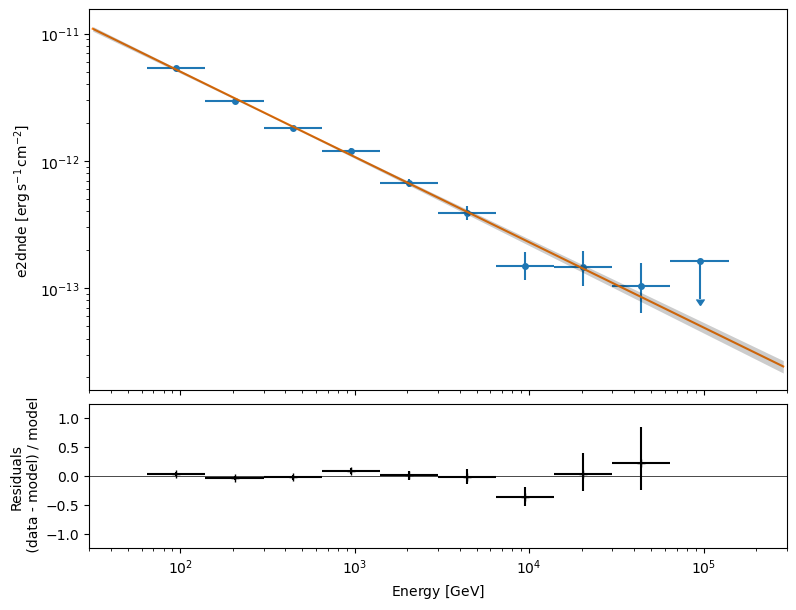

In [53]:
analysis.flux_points.plot_fit()

<Axes: xlabel='Energy [$\\mathrm{GeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>

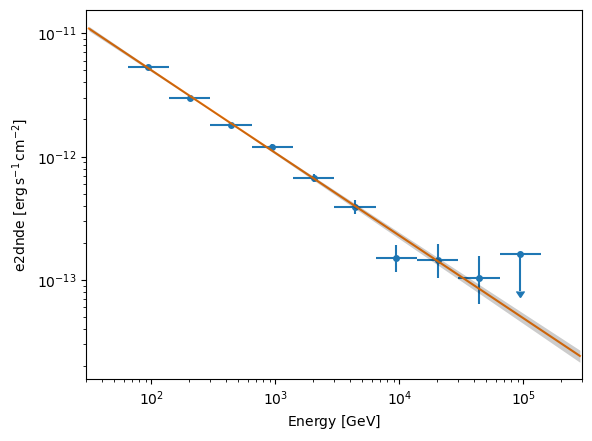

In [54]:
analysis.flux_points.plot_spectrum()

<Axes: xlabel='Energy [$\\mathrm{GeV}$]', ylabel='Residuals\n data - model'>

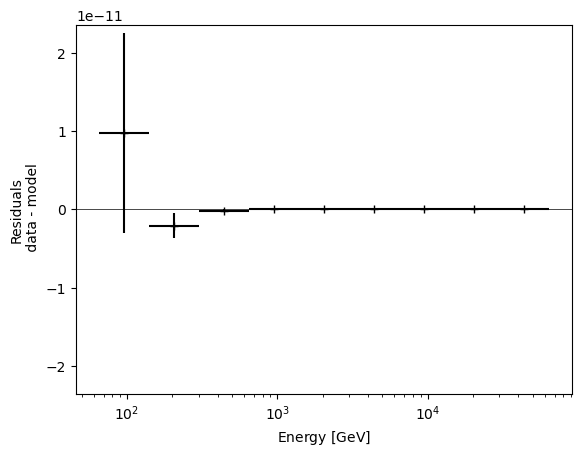

In [55]:
analysis.flux_points.plot_residuals()

## 5. Summary

In this notebook, we:

1. Selected a source from the 3HWC catalog.
2. Configured and ran a 1D ON/OFF spectrum analysis using `AnalysisSpectrum`.
3. Printed and saved the fit results and flux points for further analysis.

This modular design


## Sugestões de Exercício: Alterando a Configuração do `CTAOAnalysisConfig`

Explore diferentes aspectos da simulação espectral ajustando os parâmetros da configuração.  
Use as sugestões abaixo para gerar novos datasets e comparar os resultados com a configuração padrão.

---

### 1. Tempo de observação mais curto

```python
config.observation.livetime = 5 * u.h  # padrão era 50 h

# Exercício:
# Compare o espectro e os erros com tempos de 5 h, 10 h e 50 h.
# Como a estatística influencia o ajuste?

In [ ]:
# 2. Avaliar o modelo no centro da região ON

config.datasets.use_region_center = True  # padrão é False

# Exercício:
# Compare os espectros gerados com True e False.
# Isso afeta o fluxo normalizado ou o índice espectral?


In [ ]:
# 3. Ativar empilhamento de observações 

config.statistics.n_obs = 20 

config.datasets.stack = True

# Exercício:
# Simule múltiplas observações de 10 h e compare o ajuste com e sem empilhamento.
# Qual abordagem recupera melhor os parâmetros?


In [ ]:
# 4. Alterar o método de máscara segura

config.datasets.safe_mask.methods = ["aeff-max"]
config.datasets.safe_mask.parameters = {"aeff_percent": 10}

# Exercício:
# Compare com o método "bkg-peak".
# A faixa de energia muda?
# O ajuste é mais confiável?
